# 계층적 군집 (4) - EastWestAirlines Data

> EastWestAirlines 파일에는  항공사의 상용 고객 츠로그램에 속한 승객에 대한 정보가 포함되어있다.
>
> 각 승객에 대한 데이터에는 마일리지 내역 및 적립방식에 대한 정보가 포함되어있다.
>
> 다양한 유형의 마일리지 제공에 대해 다양한 세그먼트를 타겟팅할 목적으로 사용된다.

## 0. 군집분석에서 중요한 점

### 1) 너무 많은 변수를 사용할 위험
- 변수를 이것저것 다 넣으면 `기계가 알아서 잘'헤 주겠지...`라는 기대심리를 경계해야됨
- 변수를 너무 많이 넣을 경우
    1. 알고리즘 `실행시간 증가`
    2. 모델이 복잡해지면서 `과적합 위험 증가`
    3. 결과 `검토`에 대한 `난이도 증가`
### 2) 변수간 관계 미리보기
#### 1..변수 간의 상관관계 확인하기
1. 상관계수 히트맵
2. 산점도 행렬
- 변수 간의 유사성, 또는 군집 등을 봐서 변수의 개수 줄이기 위함
#### 2.. 주성분(PCA) 분석 활용하기
- 주성분 분석(PCA)은 데이터의 특징을 최대한 손실 없이 살리면서 데이터의 차원을 축소하는 기법
- 클러스터링 분석에서도 취급하는 변수의 수를 줄일 때 유용하게 사용할 수 있다.
### 3) 그 밖의 내용
1. 문자열 데이터 `x`
2. `이상치에 민감`하므로 이상치 `정제 혹은 표준화`를 수행할 것
- 표준화는 웬만하면 항상 하는 것을 권장
- 이상치 정제 경우는 `도메인 지식을 갖고 분석가가 판단`

## 0. 군집 분석의 결과
- 비지도학습이므로 정답이 없는 상태에서 시작하므로 훈련/검증 데이터 분할이 불필요하다
- 군집의 결과 역시 정답이 아닐 수 있다
- 적용 가능한 하이퍼 파라미터들을 다양하게 설정하여 `시각화 결과가 가장 고르게 군집`을 형성하는 경우를 선태한다. 선택 기준에 `실루엣 점수`를 반영하는 것도 고려할 수 있다


## 1. 패키지 참조

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sb
from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
from itertools import product               # 모든 경우의 조합을 뽑아주는 함수
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

## 2. 데이터 가져오기

> keggle 문제 데이터

- Balance: 보너스 여행에 적합한 마일리지
- Qual_miles: Topflight 자격 취득에 필요한 마일리지 수
- cc1_miles: 지난 12개월 동안의 신용카드 사용에 의해 적립된 마일리지
- cc2_miles: 지난 12개월 동안 Rewards 신용카드로 적립한 마일리지
- cc3_miles: 지난 12개월 동안 법인카드로 적립한 마일리지
- Bonus_miles: 지난 12개월 동안 항공권 외 보너스 거래를 통해 적립된 마일리지
- Bonus_trans: 지난 12개월 동안 항공권 외 보너스 거래 수
- Flight_miles_12mo: 지난 12개월 간 비행 마일리지
- Flight_miles_12: 지난 12개월 간 항공권 거래 건수
- Days_since_enroll: 프로그램에 가입한 일수
- Award: 보너스 항공권을 받았는지 여부

In [31]:
origin = read_excel('https://data.hossam.kr/G02/EastWestAirlines.xlsx', index_col='ID')
print(origin.info())
origin

<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 1 to 4021
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award              3999 non-null   int64
dtypes: int64(11)
memory usage: 374.9 KB
None


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0
2,19244,0,1,1,1,215,2,0,0,6968,0
3,41354,0,1,1,1,4123,4,0,0,7034,0
4,14776,0,1,1,1,500,1,0,0,6952,0
5,97752,0,4,1,1,43300,26,2077,4,6935,1
...,...,...,...,...,...,...,...,...,...,...,...
4017,18476,0,1,1,1,8525,4,200,1,1403,1
4018,64385,0,1,1,1,981,5,0,0,1395,1
4019,73597,0,3,1,1,25447,8,0,0,1402,1


## 3. 데이터 전처리
### 1) 이상치 확인
> 전문가가 아닌 이상 이상치를 정제하는 것은 현명한 판단이 아니다

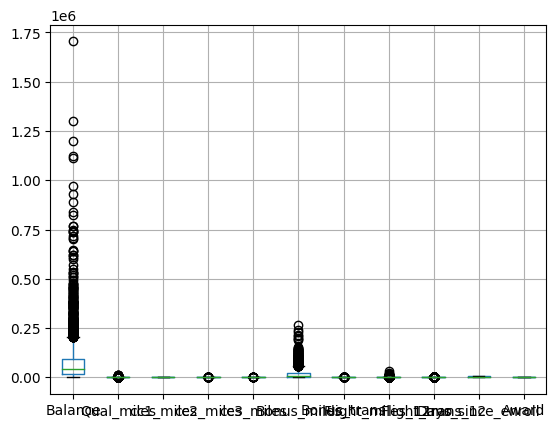

In [32]:
origin.boxplot()
plt.show()
plt.close()

### 2) 데이터 표준화 및 시각화

In [33]:
scaler = StandardScaler()
x_std = scaler.fit_transform(origin)
x_std_df = DataFrame(x_std, columns = origin.columns, index=origin.index)
x_std_df

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,-0.451141,-0.186299,-0.769578,-0.098242,-0.062767,-0.702786,-1.104065,-0.328603,-0.362168,1.395454,-0.766919
2,-0.539457,-0.186299,-0.769578,-0.098242,-0.062767,-0.701088,-0.999926,-0.328603,-0.362168,1.379957,-0.766919
3,-0.320031,-0.186299,-0.769578,-0.098242,-0.062767,-0.539253,-0.791649,-0.328603,-0.362168,1.411920,-0.766919
4,-0.583799,-0.186299,-0.769578,-0.098242,-0.062767,-0.689286,-1.104065,-0.328603,-0.362168,1.372208,-0.766919
5,0.239678,-0.186299,1.409471,-0.098242,-0.062767,1.083121,1.499394,1.154932,0.692490,1.363975,1.303918
...,...,...,...,...,...,...,...,...,...,...,...
4017,-0.547079,-0.186299,-0.769578,-0.098242,-0.062767,-0.356960,-0.791649,-0.185750,-0.098503,-1.315120,1.303918
4018,-0.091465,-0.186299,-0.769578,-0.098242,-0.062767,-0.669367,-0.687511,-0.328603,-0.362168,-1.318994,1.303918
4019,-0.000043,-0.186299,0.683121,-0.098242,-0.062767,0.343804,-0.375096,-0.328603,-0.362168,-1.315604,1.303918


<Figure size 1000x500 with 0 Axes>

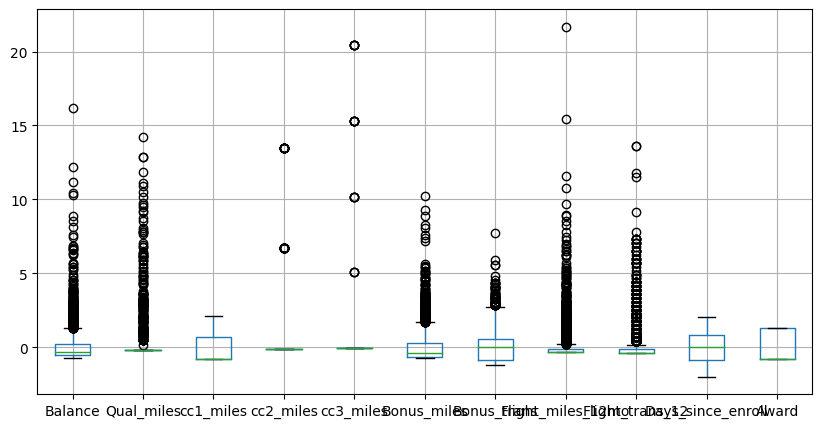

In [35]:
plt.figure(figsize=(10, 5))
x_std_df.boxplot()
plt.show()
plt.close()

### 3) 기초통계량 확인

In [36]:
x_std_df.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
count,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3999.000000,3.999000e+03,3.999000e+03,3.999000e+03
mean,2.842882e-17,6.574164e-17,1.705729e-16,3.038330e-16,1.350369e-16,-2.842882e-17,-7.817925e-17,0.000000,1.776801e-17,5.685763e-17,1.421441e-17
std,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125,1.000125e+00,1.000125e+00,1.000125e+00
min,-7.304396e-01,-1.862987e-01,-7.695784e-01,-9.824189e-02,-6.276658e-02,-7.099918e-01,-1.208203e+00,-0.328603,-3.621679e-01,-1.993611e+00,-7.669193e-01
25%,-5.465676e-01,-1.862987e-01,-7.695784e-01,-9.824189e-02,-6.276658e-02,-6.582276e-01,-8.957878e-01,-0.328603,-3.621679e-01,-8.661823e-01,-7.669193e-01
50%,-3.027332e-01,-1.862987e-01,-7.695784e-01,-9.824189e-02,-6.276658e-02,-4.130308e-01,4.145743e-02,-0.328603,-3.621679e-01,-1.092530e-02,-7.669193e-01
75%,1.866028e-01,-1.862987e-01,6.831212e-01,-9.824189e-02,-6.276658e-02,2.756198e-01,5.621492e-01,-0.106466,-9.850333e-02,8.097050e-01,1.303918e+00
max,1.618884e+01,1.422486e+01,2.135821e+00,1.344898e+01,2.042732e+01,1.020957e+01,7.747696e+00,21.683004,1.361205e+01,2.023095e+00,1.303918e+00


### 4) 각 변수 간의 상관관계 행렬 및 산점도 행렬 시각화

In [38]:
x_std_df.corr()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
Balance,1.000000,0.108722,0.338344,-0.008804,0.035243,0.403487,0.324935,0.217551,0.255700,0.263129,0.178494
Qual_miles,0.108722,1.000000,0.007931,-0.013923,-0.007779,0.031021,0.050725,0.126774,0.144004,0.017312,0.095256
cc1_miles,0.338344,0.007931,1.000000,-0.068223,0.060555,0.825200,0.608943,0.037370,0.041333,0.230849,0.335457
cc2_miles,-0.008804,-0.013923,-0.068223,1.000000,-0.006166,-0.003969,0.064399,0.010598,0.028284,-0.005807,0.005332
cc3_miles,0.035243,-0.007779,0.060555,-0.006166,1.000000,0.204134,0.097313,-0.001777,-0.001117,0.010832,0.023484
Bonus_miles,0.403487,0.031021,0.825200,-0.003969,0.204134,1.000000,0.603180,0.183536,0.185261,0.210397,0.373506
Bonus_trans,0.324935,0.050725,0.608943,0.064399,0.097313,0.603180,1.000000,0.377216,0.432364,0.161262,0.333893
Flight_miles_12mo,0.217551,0.126774,0.037370,0.010598,-0.001777,0.183536,0.377216,1.000000,0.869193,0.037271,0.217715
Flight_trans_12,0.255700,0.144004,0.041333,0.028284,-0.001117,0.185261,0.432364,0.869193,1.000000,0.059260,0.247909
Days_since_enroll,0.263129,0.017312,0.230849,-0.005807,0.010832,0.210397,0.161262,0.037271,0.059260,1.000000,0.188121


<Figure size 640x480 with 0 Axes>

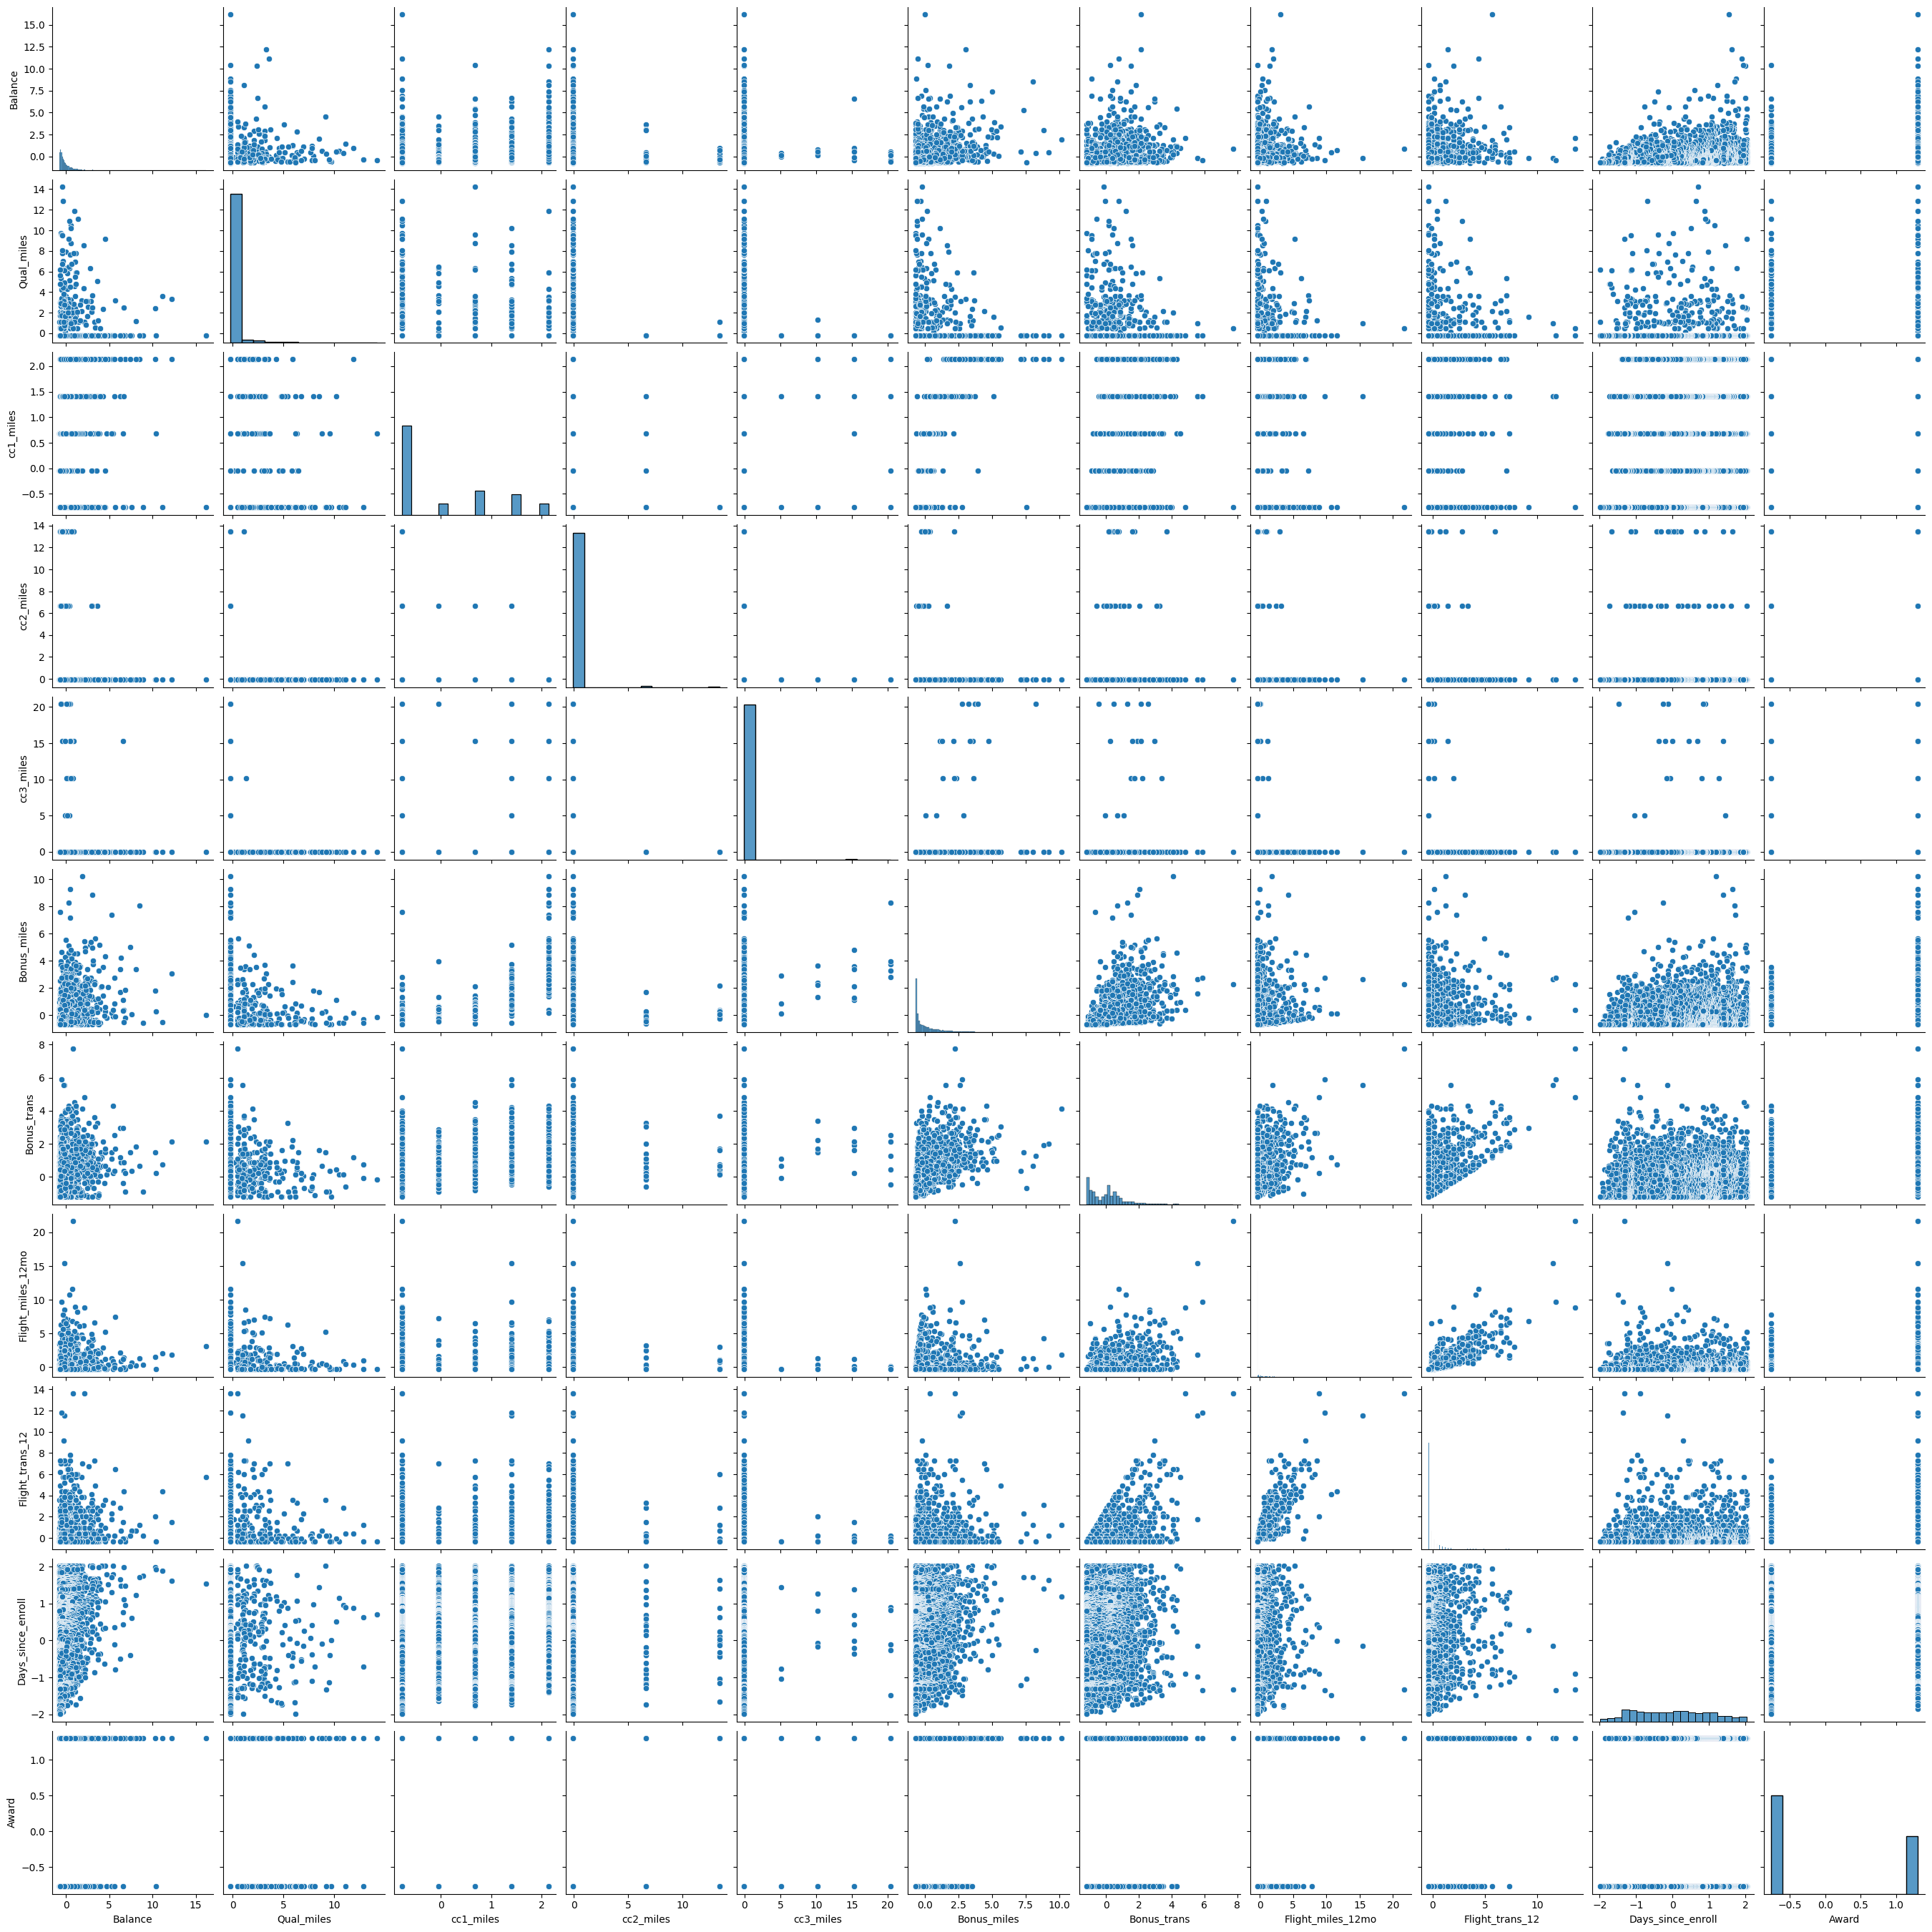

In [37]:
plt.figure()
sb.pairplot(x_std_df)
plt.show()
plt.close()

### 6) 상관계수 히트맵
- 히트맵을 통해서 특별히 높은 상관을 보이는 변수 묶음들이 있는지 확인 가능
- 묶음 별로 상대적으로 중요도가 낮다고 판단되는 변수는 분석에서 제외할 수 있다

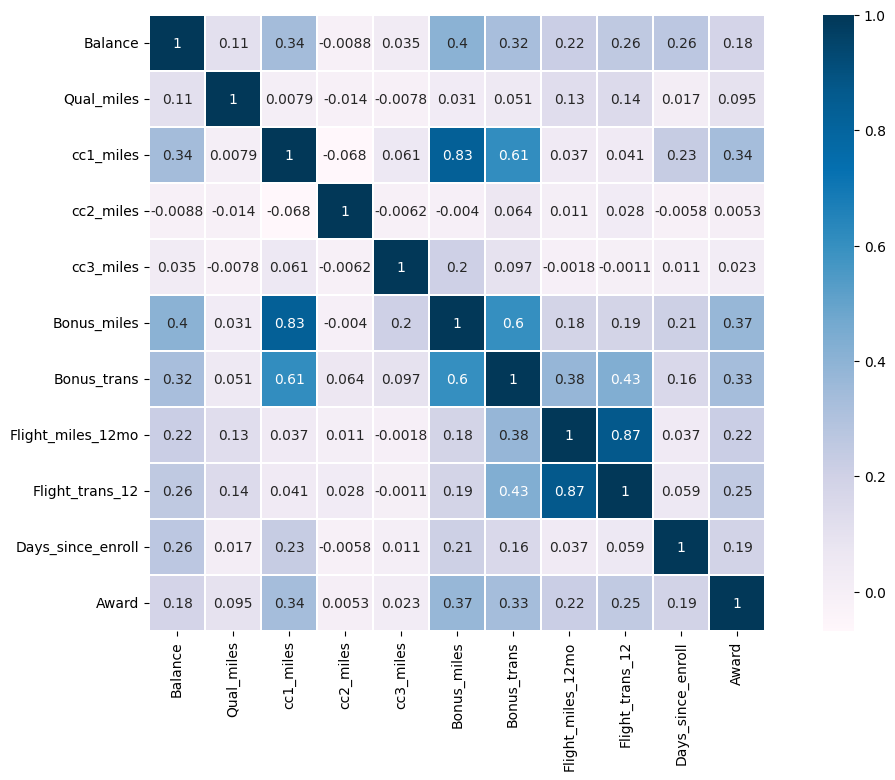

In [39]:
plt.figure(figsize=(15, 8))
sb.heatmap(x_std_df.corr(), 
           linewidths = 0.1, 
           vmax=1.0,
           square=True,
           cmap=plt.cm.PuBu,
           linecolor='white',
           annot=True,
           annot_kws={'size':10})
plt.show()
plt.close()

> 상관계수 히트맵 확인 결과 Balance, cc1_miles, Bonus_miles, Bonus_trans, Flight_miles_12mo, Flight_trans_12를 주요 변수로 판단하고 선정하였다
>
> 실무에서는 변수 선정의 이유에 대한 근거자료들을 제시해줘야 됨

### 7) 대상 변수 필터링

In [41]:
# 예제 구성을 위해 테스트 한 다른 변수집합들
# -> 모두 3개의 군집을 형성하였음
# x = x_std_df.filter(['Balance','cc1_miles','Bonus_miles','Bonus_trans', 
#                      'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll'])
# x = x_std_df.filter(['Balance','cc1_miles','cc2_miles','cc3_miles','Bonus_miles', 
#                      'Bonus_trans', 'Days_since_enroll'])

# 최종 선정된 변수 집합
x = x_std_df.filter(['Balance', 'cc1_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 
                     'Flight_trans_12'])
x

,Balance,cc1_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12
ID,,,,,,
1,-0.451141,-0.769578,-0.702786,-1.104065,-0.328603,-0.362168
2,-0.539457,-0.769578,-0.701088,-0.999926,-0.328603,-0.362168
3,-0.320031,-0.769578,-0.539253,-0.791649,-0.328603,-0.362168
4,-0.583799,-0.769578,-0.689286,-1.104065,-0.328603,-0.362168
5,0.239678,1.409471,1.083121,1.499394,1.154932,0.692490
...,...,...,...,...,...,...
4017,-0.547079,-0.769578,-0.356960,-0.791649,-0.185750,-0.098503
4018,-0.091465,-0.769578,-0.669367,-0.687511,-0.328603,-0.362168
4019,-0.000043,0.683121,0.343804,-0.375096,-0.328603,-0.362168


## 4. 군집 분석 수행
- 시각화하기 편한 `scipy`로 분석해본 후 그 결과로 `sklearn`로 분석 
    - 이유:
        - scipy: 시각화 용이, 그러나 각각의 데이터에 대한 정보 반환 안 해줌 -> '군집을 몇 개로 나눠야 되겠다'라는 감 잡기용
        - sklearn: 시각화하기 힘듦, 그러나 각각의 데이터가 몇 번째의 클러스터에 속해있다는 정보를 반환해줌 -> 앞서 `scipy를 통해 선정한 군집의 개수`를 `sklearn을 사용하여 설정`해 봄으로 `최적의 군집수를 찾고` 그 군집수에 해당하는 `데이터 얻기`
- **method가 `centroid나 ward`일 경우, metric은 `euclidean`만 적용 가능하다 - 다른 metrics는 적용 불가**

In [43]:
method = ['single', 'complete', 'average', 'weighted', 'centroid', 'ward'] # 많이 사용하는 것은 single, complete, average, ward; 시간이 너무 오래 걸릴듯 하면 이 4개만 해보는 것을 권장
metric = ['euclidean', 'cityblock'] # 많이 사용하는 것만 추림 # cityblock은 manhattan임

# 두 개의 리스트 조합
prod = list(product(*[method, metric]))
prod

[('single', 'euclidean'),
 ('single', 'cityblock'),
 ('complete', 'euclidean'),
 ('complete', 'cityblock'),
 ('average', 'euclidean'),
 ('average', 'cityblock'),
 ('weighted', 'euclidean'),
 ('weighted', 'cityblock'),
 ('centroid', 'euclidean'),
 ('centroid', 'cityblock'),
 ('ward', 'euclidean'),
 ('ward', 'cityblock')]

### 1) scipy 패키지 사용

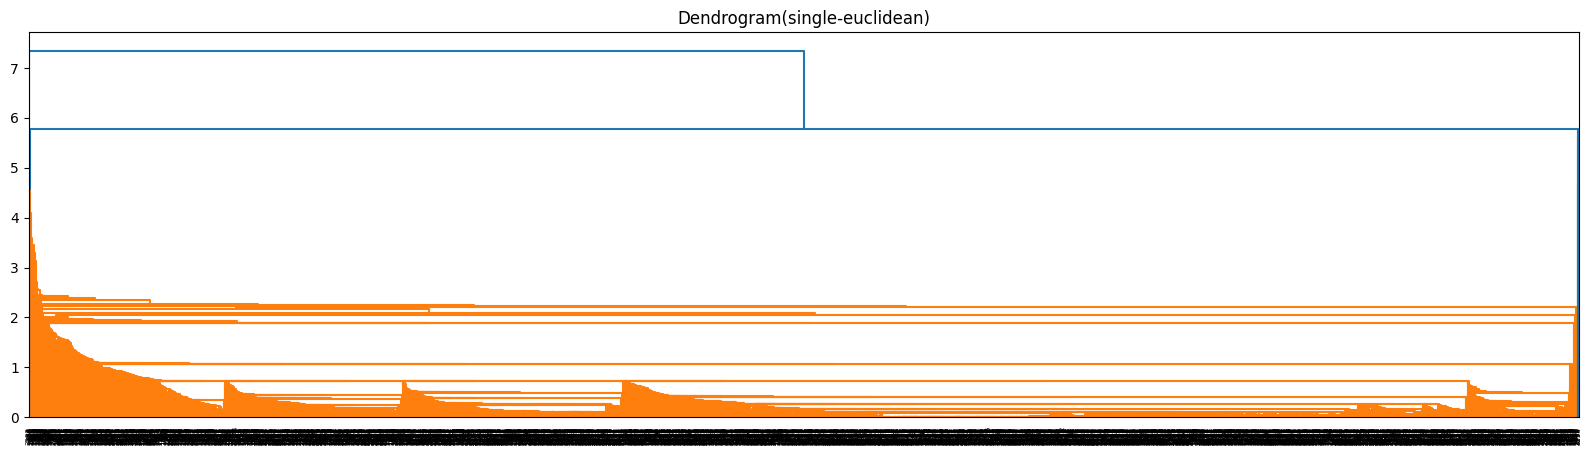

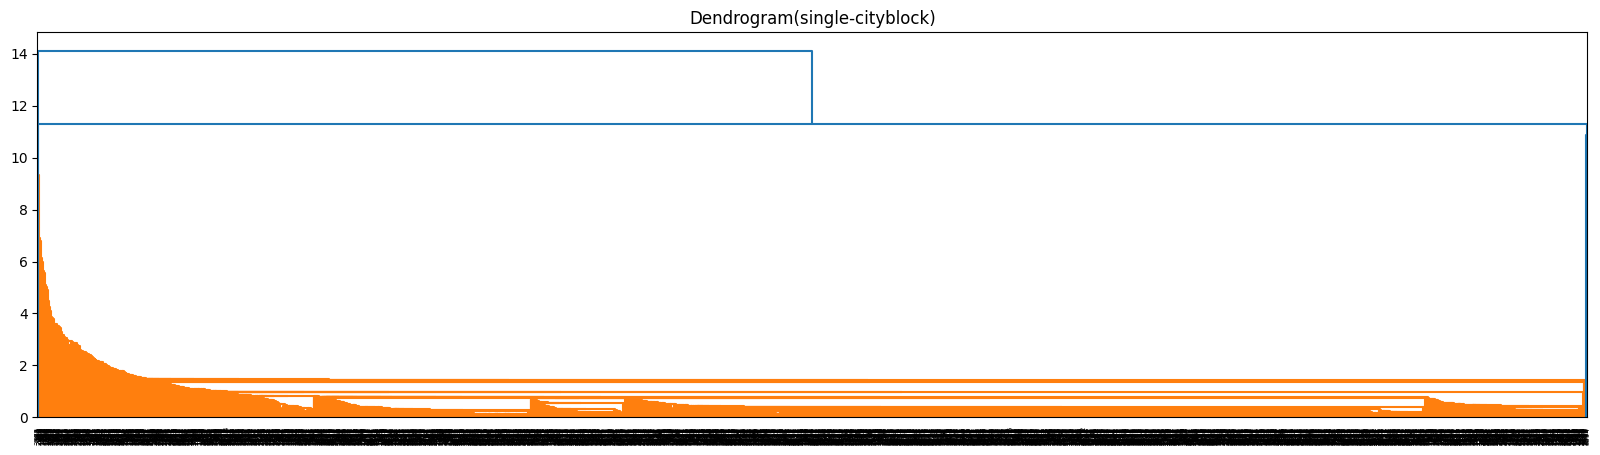

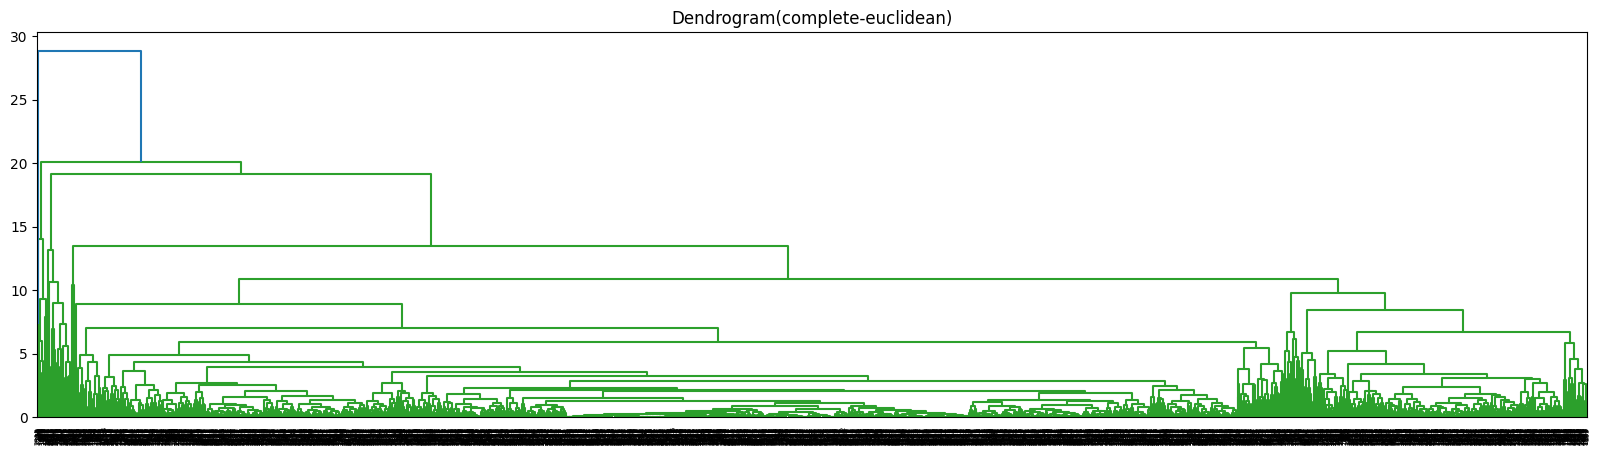

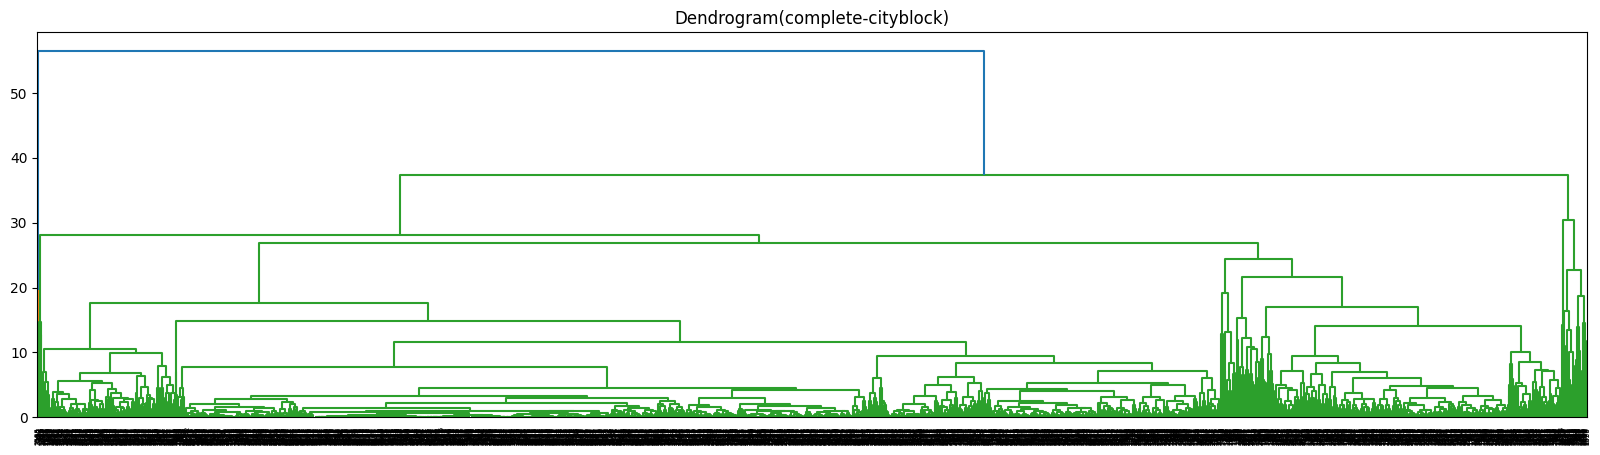

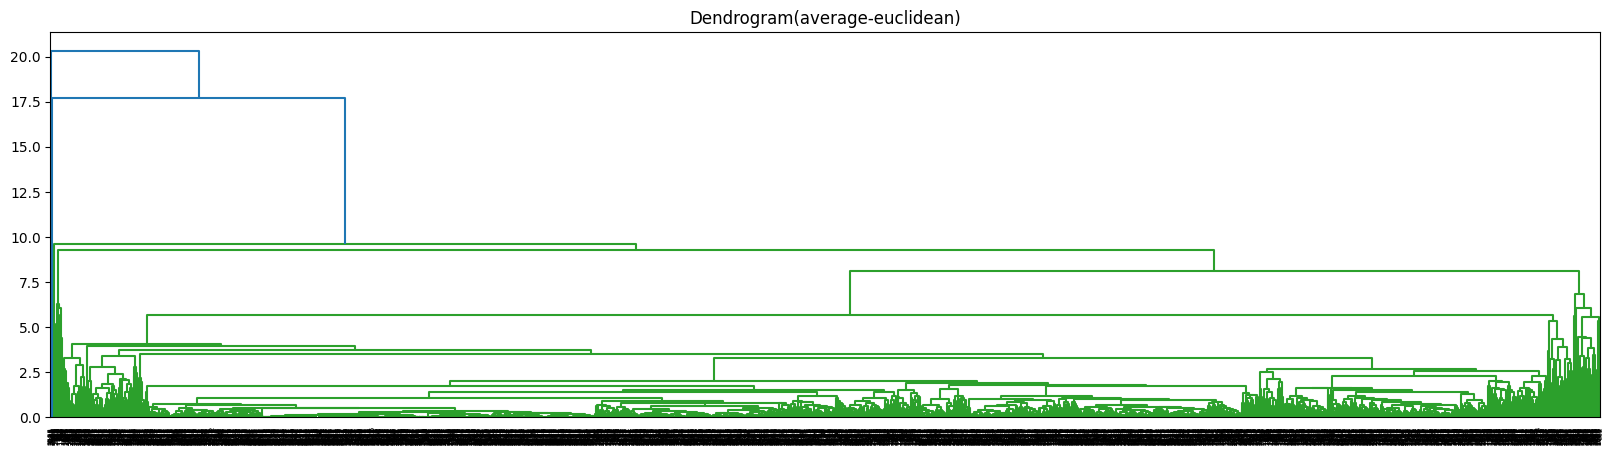

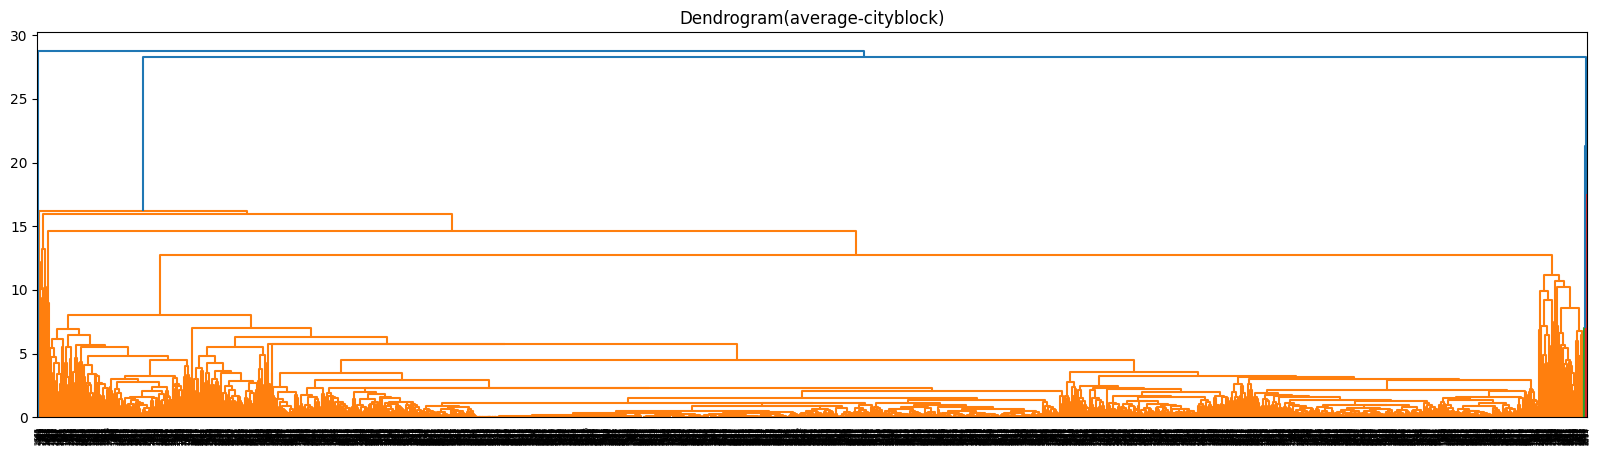

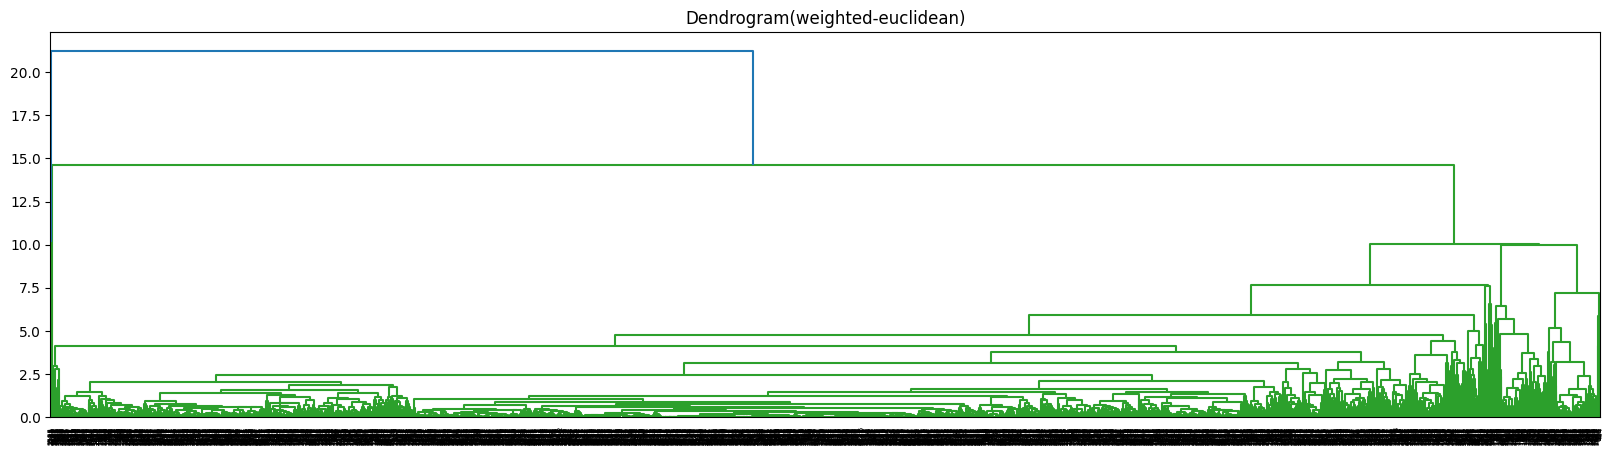

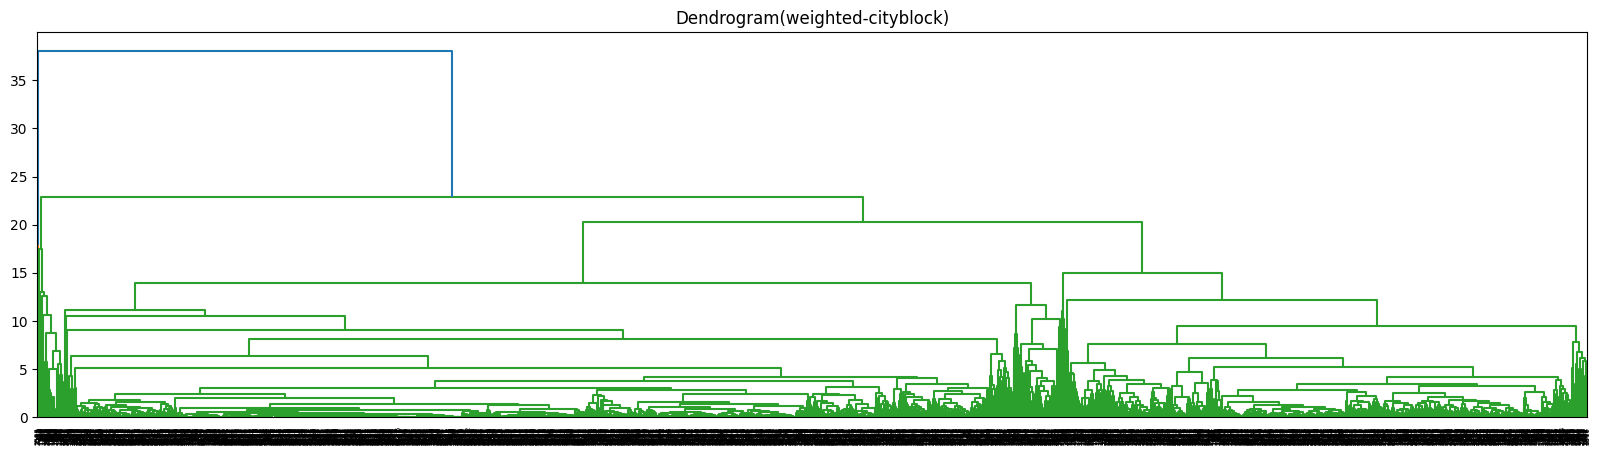

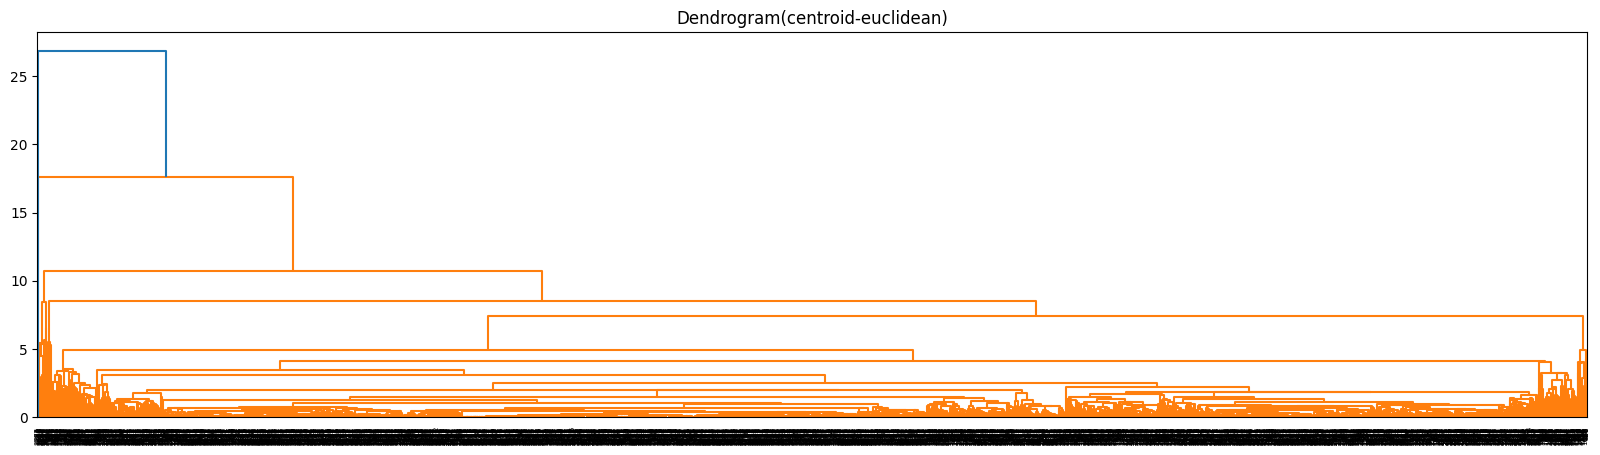

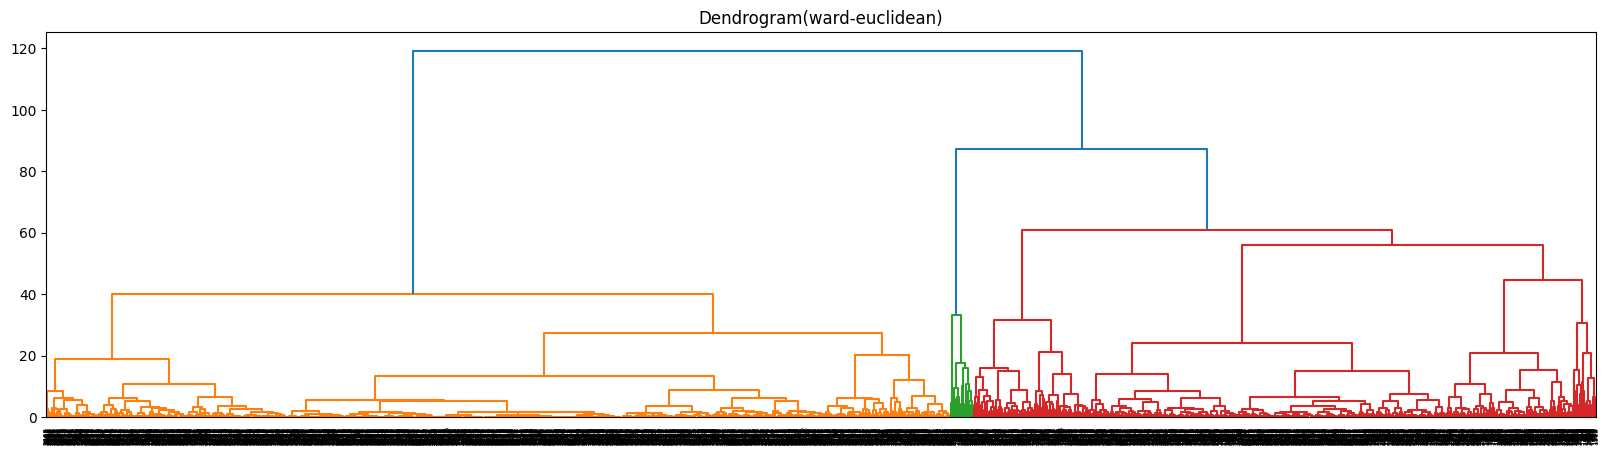

In [46]:
for method, metric in prod:
    # method가 centroid/ward일 경우 euclidean만 가능하기에 아래의 반복문 형성
    if method in ['centroid', 'ward'] and metric != 'euclidean':
        continue

    z = linkage(x, method=method, metric=metric)

    plt.figure(figsize=(20, 5))
    dendrogram(z)
    plt.title(f'Dendrogram({method}-{metric})')
    plt.show()
    plt.close()

### 2) 군집 결과값을 sklearn 패키지에 적용
- 각 개별 데이터가 어떤 군집에 속하는가를 알아보기 위해서는 sklearn을 사용하는 것이 간편하다

In [47]:
h_complete = AgglomerativeClustering(n_clusters=3,
                                     metric='cityblock',
                                     linkage='complete')
h_complete.fit(x)
h_complete.labels_

array([2, 2, 2, ..., 2, 2, 2])

- 원본 데이터에 클러스터링 결과를 병합
- 각 고객이 어떤 클러스터에 속하는가를 확인할 수 있는 데이터가 된다

In [48]:
origin['Cluster'] = h_complete.labels_
origin

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Cluster
ID,,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0,2
2,19244,0,1,1,1,215,2,0,0,6968,0,2
3,41354,0,1,1,1,4123,4,0,0,7034,0,2
4,14776,0,1,1,1,500,1,0,0,6952,0,2
5,97752,0,4,1,1,43300,26,2077,4,6935,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
4017,18476,0,1,1,1,8525,4,200,1,1403,1,2
4018,64385,0,1,1,1,981,5,0,0,1395,1,2
4019,73597,0,3,1,1,25447,8,0,0,1402,1,2


In [49]:
origin['Cluster'].value_counts()

Cluster
2    3930
0      65
1       4
Name: count, dtype: int64

> 나눠진 그룹들 중 가장 작은 수를 가진 그룹이 가장 많이 지출한 고객으로 예상

### 3) VIP 고객 등급 추출

In [50]:
origin.query('Cluster==1')

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Cluster
ID,,,,,,,,,,,,
2032,53232,888,4,1,1,80696,65,22100,45,3831,1,1
3257,287033,0,1,1,1,26161,58,12873,53,2272,1,1
3606,160114,500,1,1,1,71954,86,30817,53,1373,1,1
3617,27619,0,4,1,1,83726,68,14050,46,1325,1,1
